# OONI Data Analysis - Preliminary Exploration

In [1]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

In [2]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [3]:
# Load the pre-processed data and set up the index based on date
data_dir = '../../Data/NP/processed/2022/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,http_experiment_failure,x_dns_flags,status_code_match,resolver_asn,headers_match,blocking,body_length_match,input,control_failure,title_match,accessible,x_null_null_flags,x_blocking_flags,body_proportion,dns_consistency,dns_experiment_failure
date,,,,,,,,,,,,,,,,,
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://fteproxy.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.sbc.net/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.ecequality.org/,NaN,True,True,NaN,NaN,1.000000,inconsistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.episcopalchurch.org/,NaN,True,True,NaN,NaN,1.000000,consistent,NaN
2022-01-02,AS17501,NaN,NaN,True,AS17501,True,False,True,http://www.icrw.org/,NaN,True,True,NaN,NaN,0.999723,consistent,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,True,https://www.facebook.com/,NaN,NaN,True,NaN,NaN,0.975015,consistent,NaN
2022-12-31,AS23752,NaN,NaN,False,AS23752,True,False,NaN,https://www.instagram.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN
2022-12-31,AS23752,NaN,NaN,True,AS23752,True,False,NaN,https://www.youtube.com/,NaN,NaN,True,NaN,NaN,0.000000,consistent,NaN


In [4]:
# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)

In [5]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'dns', 'http-diff', 'http-failure', nan, 'tcp_ip'],
      dtype=object)

## (2) Data Exploration

In [6]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [7]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

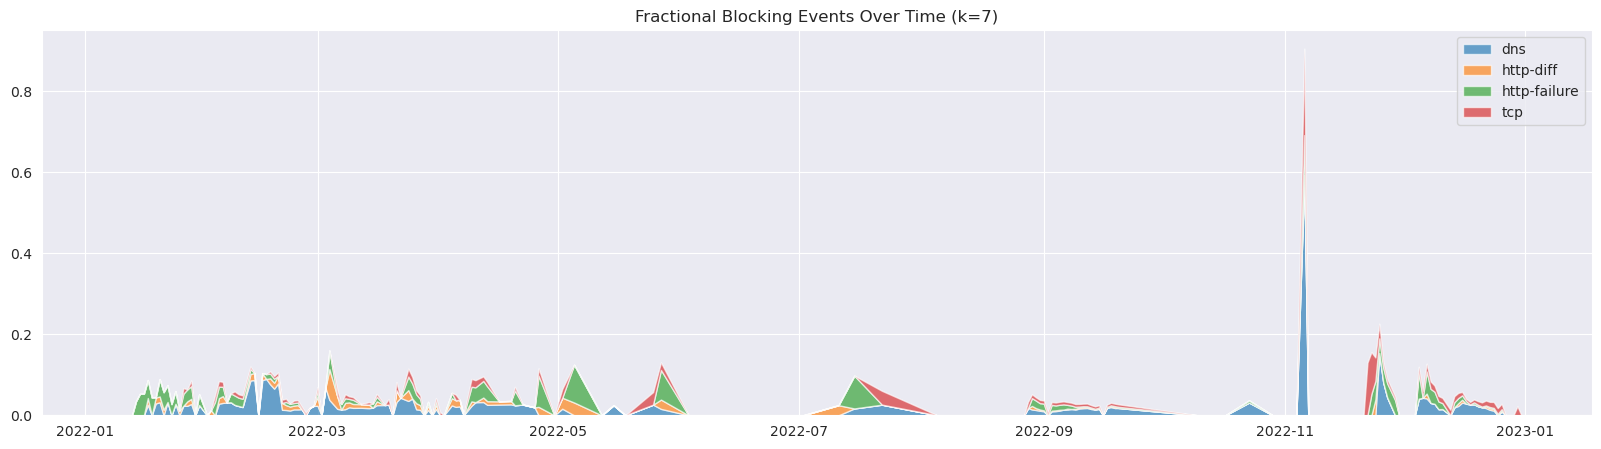

In [8]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2022-10-01-2022-12-01 (k=7)')

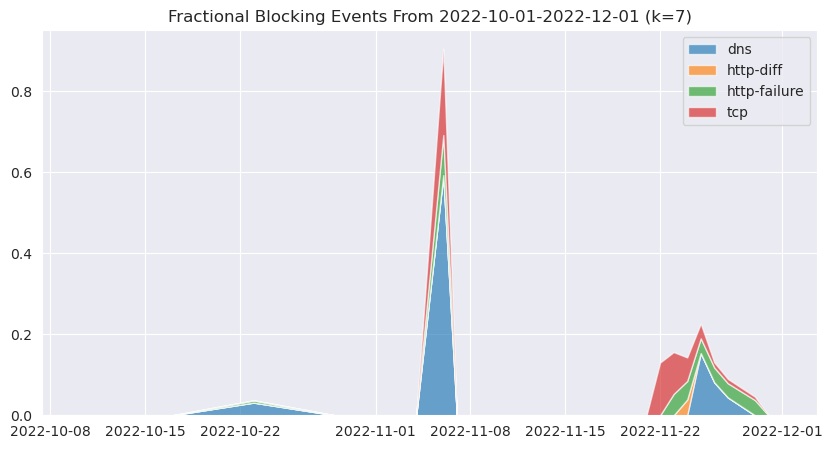

In [9]:
# Zoom in on a region of interest
start_date = '2022-10-01'
end_date = '2022-12-01'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [10]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn http_experiment_failure  \
input                          date                                           
0.39:9131/tor/server/authority 2022-03-06  AS140989   generic_timeout_error   
                               2022-03-24  AS140989   generic_timeout_error   
                               2022-03-26  AS140989   generic_timeout_error   
                               2022-03-31  AS140989   generic_timeout_error   
                               2022-11-06   AS23752      connection_refused   
...                                             ...                     ...   
yourvoyeurvideos.com/          2022-09-18   AS17501                     NaN   
                               2022-12-16   AS17501                     NaN   
youtube.com/                   2022-11-24   AS23752   generic_timeout_error   
zoomshare.com/                 2022-02-23   AS45650   generic_timeout_error   
zzn.com/                       2022-02-17   AS17501                     NaN   

                                           x_dns_flags status_code_match  \
input                          date                                        
0.39:9131/tor/server/authority 2022-03-06          NaN               NaN   
                               2022-03-24          NaN               NaN   
                               2022-03-26          NaN               NaN   
                               2022-03-31          NaN               NaN   
                               2022-11-06          NaN               NaN   
...                                                ...               ...   
yourvoyeurvideos.com/          2022-09-18          NaN              True   
                               2022-12-16          NaN              True   
youtube.com/                   2022-11-24          NaN               NaN   
zoomshare.com/                 2022-02-23          NaN               NaN   
zzn.com/                       2022-02-17          NaN               NaN   

                                          resolver_asn headers_match  \
input                          date                                    
0.39:9131/tor/server/authority 2022-03-06     AS140989           NaN   
                               2022-03-24     AS140989           NaN   
                               2022-03-26     AS140989           NaN   
                               2022-03-31     AS140989           NaN   
                               2022-11-06      AS23752           NaN   
...                                                ...           ...   
yourvoyeurvideos.com/          2022-09-18      AS17501         False   
                               2022-12-16      AS17501         False   
youtube.com/                   2022-11-24      AS23752           NaN   
zoomshare.com/                 2022-02-23      AS45170           NaN   
zzn.com/                       2022-02-17      AS17501           NaN   

                                               blocking body_length_match  \
input                          date                                         
0.39:9131/tor/server/authority 2022-03-06        tcp_ip               NaN   
                               2022-03-24        tcp_ip               NaN   
                               2022-03-26        tcp_ip               NaN   
                               2022-03-31        tcp_ip               NaN   
                               2022-11-06        tcp_ip               NaN   
...                                                 ...               ...   
yourvoyeurvideos.com/          2022-09-18           dns             False   
                               2022-12-16           dns             False   
youtube.com/                   2022-11-24  http-failure               NaN   
zoomshare.com/                 2022-02-23  http-failure               NaN   
zzn.com/                       2022-02-17           dns               NaN   

                                          control_failure title_match  \
input        

In [11]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
206.212/tor/server/authority       67
planetromeo.com/                   67
gaytoday.com/                      52
pinkcupid.com/                     47
newnownext.com/                    46
                                   ..
yandex.ru/                          1
ymca.int/                           1
fbcdn.net/favicon.ico               1
feminist.com/                       1
2.131:9030/tor/server/authority     1
Length: 565, dtype: int64

In [12]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn http_experiment_failure  \
input                        date                                           
206.212/tor/server/authority 2022-03-09   AS24550   generic_timeout_error   
                             2022-04-26  AS140989   generic_timeout_error   
                             2022-07-22   AS17501   generic_timeout_error   
                             2022-08-28   AS45650   generic_timeout_error   
                             2022-08-29   AS17501               timed_out   
...                                           ...                     ...   
sexandthecitymovie.com/dvd/  2022-09-10   AS17501                     NaN   
                             2022-09-12   AS17501                     NaN   
                             2022-09-15   AS17501                     NaN   
                             2022-09-17   AS17501                     NaN   
                             2022-12-16   AS17501                     NaN   

                                         x_dns_flags status_code_match  \
input                        date                                        
206.212/tor/server/authority 2022-03-09          NaN               NaN   
                             2022-04-26          NaN               NaN   
                             2022-07-22          NaN               NaN   
                             2022-08-28          NaN               NaN   
                             2022-08-29          NaN               NaN   
...                                              ...               ...   
sexandthecitymovie.com/dvd/  2022-09-10          NaN             False   
                             2022-09-12          NaN             False   
                             2022-09-15          NaN             False   
                             2022-09-17          NaN             False   
                             2022-12-16          NaN             False   

                                        resolver_asn headers_match blocking  \
input                        date                                             
206.212/tor/server/authority 2022-03-09      AS24550           NaN   tcp_ip   
                             2022-04-26     AS140989           NaN   tcp_ip   
                             2022-07-22      AS17501           NaN   tcp_ip   
                             2022-08-28      AS45650           NaN   tcp_ip   
                             2022-08-29      AS15169           NaN   tcp_ip   
...                                              ...           ...      ...   
sexandthecitymovie.com/dvd/  2022-09-10      AS17501         False      dns   
                             2022-09-12      AS17501         False      dns   
                             2022-09-15      AS17501         False      dns   
                             2022-09-17      AS17501         False      dns   
                             2022-12-16      AS17501         False      dns   

                                        body_length_match control_failure  \
input                        date                                           
206.212/tor/server/authority 2022-03-09               NaN             NaN   
                             2022-04-26               NaN             NaN   
                             2022-07-22               NaN             NaN   
                             2022-08-28               NaN             NaN   
                             2022-08-29               NaN             NaN   
...                                                   ...             ...   
sexandthecitymovie.com/dvd/  2022-09-10               NaN             NaN   
                             2022-09-12               NaN             NaN   
                             2022-09-15               NaN             NaN   
                             2022-09-17               NaN             NaN   
                             2022-12-16               NaN             NaN   

                                        title

In [13]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [14]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [15]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
0.39:9131/tor/server/authority,0.000000,0.0,0.000000,0.098592
150m.com/,0.000000,0.0,0.038462,0.346154
163.com/,0.000000,0.0,0.071429,0.000000
164.118/tor/server/authority,0.000000,0.0,0.000000,0.015385
175.225/tor/server/authority,0.000000,0.0,0.000000,0.238095
...,...,...,...,...
youporn.com/,0.478261,0.0,0.130435,0.000000
yourvoyeurvideos.com/,0.375000,0.0,0.125000,0.000000
youtube.com/,0.000000,0.0,0.001294,0.000000


In [16]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
venus.com/,0.208333,0.791667,0.000000,0.0
terrorismfiles.org/,0.000000,1.000000,0.000000,0.0
torrentz.eu/,1.000000,0.000000,0.000000,0.0
kurtuluscephesi.com/,0.777778,0.222222,0.000000,0.0
flirtylingerie.com/,0.000000,0.500000,0.500000,0.0
...,...,...,...,...
coinbase.com/,0.333333,0.000000,0.000000,0.0
mininova.org/,0.333333,0.000000,0.000000,0.0
collegehumor.com/,0.250000,0.000000,0.083333,0.0


In [17]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 0, 'Fraction of events')

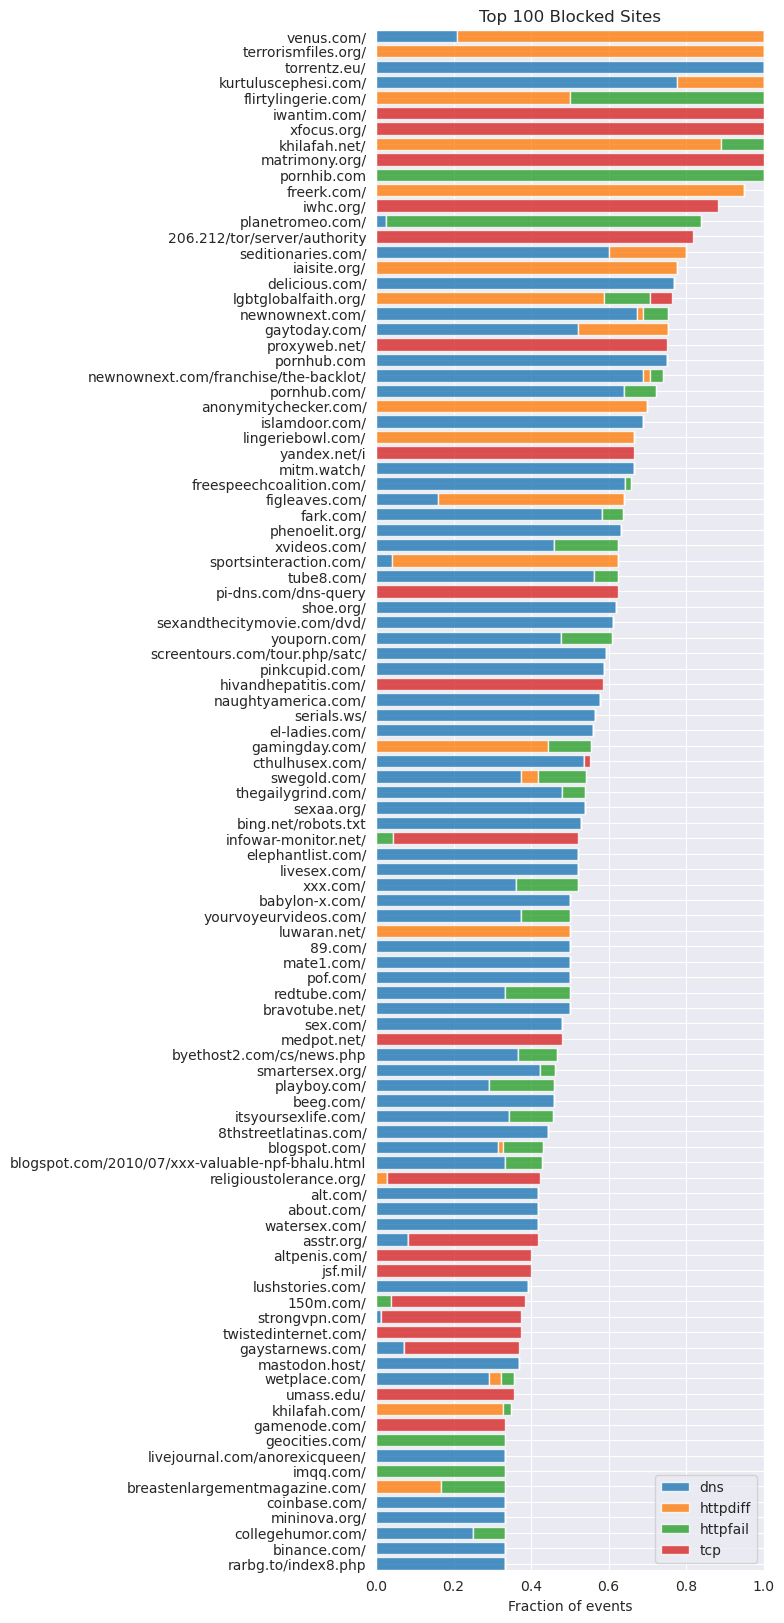

In [18]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')
plt.xlabel('Fraction of events')